## 0. Set up

In [ ]:
! pip install transformers datasets evaluate scikit-learn
! pip install accelerate -U

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer
from datasets import load_dataset
from datasets import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

import re
import string

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## 1. Load dataset
I will use the HC3 (Human ChatGPT Comparison Corpus) dataset from the 🤗 Datasets library.

In [ ]:
ds = load_dataset("hello-simpleai/hc3", data_files=['all.jsonl' ])

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'human_answers', 'chatgpt_answers', 'index', 'source'],
        num_rows: 24322
    })
})

In [ ]:
ds['train'][5]['human_answers'][0]

'Melanin ! Many of the the first known humans existed in the fertile crescent - modern day Iraq and surrounding areas , and it was just as sunny and hot as it is today . Melanin causes skin and eyes to have a darker color , and as a benefit reduced the amount of UV radiation absorbed into the skin . Eventually humans expanded into less hot and sunlit areas allowing for the survival and procreation of people who developed lighter colored eyes and skin because of the lack of need of melanin for survival .'

In [ ]:
ds['train'][5]['chatgpt_answers'][0]

'The color of your eyes is determined by the amount and type of pigments in your iris, which is the colored part of your eye, and by the way that the iris scatters light. The iris contains two types of pigment: one called melanin, which gives your skin, hair, and eyes their color, and another called lipochrome, which is a yellowish pigment. The combination of these pigments, along with the structure of the iris, determines the color of your eyes. \nThere are many different shades of eye color, ranging from dark brown to light blue, and the most common eye colors are brown, blue, and green. The color of your eyes is determined by your genes, which are the instructions that you inherit from your parents that tell your body how to grow and function. \nThere is no scientific evidence to suggest that the color of your eyes has any special meaning or significance. However, many people believe that the color of your eyes can reveal certain things about your personality or your health, but the

## 2. Data Preprocessing and Save
The next step is to load a tokenizer to preprocess the text field. A tokenizer converts text to a sequence of tokens and creates numerical representation.

In [ ]:
# tokenizer
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# tokenizer test
text = "Hello everyone!"
vocab = {v:k for k,v in roberta_tokenizer.vocab.items()}
print([(id, vocab[id]) for id in roberta_tokenizer(text)['input_ids']])
print([(id, vocab[id]) for id in roberta_tokenizer(ds['train'][3]['human_answers'][0])['input_ids']])

[(0, '<s>'), (31414, 'Hello'), (961, 'Ġeveryone'), (328, '!'), (2, '</s>')]
[(0, '<s>'), (1185, 'You'), (6056, 'Ġca'), (295, 'Ġn'), (75, "'t"), (95, 'Ġjust'), (213, 'Ġgo'), (198, 'Ġaround'), (39257, 'Ġassass'), (15647, 'inating'), (5, 'Ġthe'), (917, 'Ġleaders'), (9, 'Ġof'), (749, 'Ġcountries'), (47, 'Ġyou'), (109, 'Ġdo'), (295, 'Ġn'), (90, 't'), (101, 'Ġlike'), (27785, 'Ġ!'), (20, 'ĠThe'), (758, 'Ġinternational'), (19973, 'Ġcondemnation'), (74, 'Ġwould'), (28, 'Ġbe'), (8513, 'Ġbrutal'), (479, 'Ġ.'), (1648, 'ĠEven'), (600, 'Ġthough'), (117, 'Ġno'), (1264, 'one'), (3829, 'Ġlikes'), (1636, 'ĠKim'), (6465, 'ĠJong'), (111, 'Ġ-'), (1890, 'ĠUn'), (2156, 'Ġ,'), (8, 'Ġand'), (961, 'Ġeveryone'), (4265, 'Ġthinks'), (369, 'ĠNorth'), (1101, 'ĠKorea'), (16, 'Ġis'), (1256, 'Ġpretty'), (43816, 'Ġshitty'), (7, 'Ġto'), (63, 'Ġits'), (2286, 'Ġcitizens'), (2156, 'Ġ,'), (114, 'Ġif'), (224, 'Ġsay'), (5, 'Ġthe'), (382, 'ĠUS'), (58, 'Ġwere'), (7, 'Ġto'), (2142, 'Ġsend'), (3525, 'Ġagents'), (81, 'Ġover'), (36,

In [ ]:
#Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
# making dataframe include human answers
question_list = []
human_answer_list = []
index_list = []
source_list = []
input_ids_list = []
attention_mask_list = []
label_list = []

for sample in ds['train']:

  # some of the question does not have answer.
  if len(sample['human_answers'])!=0:
    one_human_answer = sample['human_answers'][0]

    question_list.append(sample['question'])
    human_answer_list.append([clean_text(one_human_answer)])
    index_list.append(sample['index'])
    source_list.append(sample['source'])
    input_ids_list.append(roberta_tokenizer(one_human_answer, truncation=True)['input_ids'])
    attention_mask_list.append(roberta_tokenizer(one_human_answer, truncation=True)['attention_mask'])
    label_list.append(0)

tokenized_human_answers_df = pd.DataFrame.from_dict({'question':question_list, 'answer':human_answer_list, 'index':index_list, \
                                                       'source':source_list, 'input_ids':input_ids_list, 'attention_mask':attention_mask_list, \
                                                      'label':label_list})

In [ ]:
# making dataframe include chatgpt answers
question_list = []
chatgpt_answer_list = []
index_list = []
source_list = []
input_ids_list = []
attention_mask_list = []
label_list = []

for sample in ds['train']:

  # some of the question does not have answer.
  if len(sample['chatgpt_answers'])!=0:
    one_chatgpt_answer = sample['chatgpt_answers'][0]

    question_list.append(sample['question'])
    chatgpt_answer_list.append([clean_text(one_chatgpt_answer)])
    index_list.append(sample['index'])
    source_list.append(sample['source'])
    input_ids_list.append(roberta_tokenizer(one_chatgpt_answer, truncation=True)['input_ids'])
    attention_mask_list.append(roberta_tokenizer(one_chatgpt_answer, truncation=True)['attention_mask'])
    label_list.append(1)


tokenized_chatgpt_answers_df = pd.DataFrame.from_dict({'question':question_list, 'answer':chatgpt_answer_list, 'index':index_list, \
                                                       'source':source_list, 'input_ids':input_ids_list, 'attention_mask':attention_mask_list, \
                                                      'label':label_list})

In [ ]:
# shows clean texts
tokenized_human_answers_df.loc[5]['answer']

['melanin  many of the the first known humans existed in the fertile crescent  modern day iraq and surrounding areas  and it was just as sunny and hot as it is today  melanin causes skin and eyes to have a darker color  and as a benefit reduced the amount of uv radiation absorbed into the skin  eventually humans expanded into less hot and sunlit areas allowing for the survival and procreation of people who developed lighter colored eyes and skin because of the lack of need of melanin for survival ']

In [ ]:
# shows clean texts
tokenized_chatgpt_answers_df.loc[5]['answer']

['the color of your eyes is determined by the amount and type of pigments in your iris which is the colored part of your eye and by the way that the iris scatters light the iris contains two types of pigment one called melanin which gives your skin hair and eyes their color and another called lipochrome which is a yellowish pigment the combination of these pigments along with the structure of the iris determines the color of your eyes there are many different shades of eye color ranging from dark brown to light blue and the most common eye colors are brown blue and green the color of your eyes is determined by your genes which are the instructions that you inherit from your parents that tell your body how to grow and function there is no scientific evidence to suggest that the color of your eyes has any special meaning or significance however many people believe that the color of your eyes can reveal certain things about your personality or your health but these beliefs are not support

In [ ]:
def add_token_padding(sample):

  if len(sample)<512:

    token_paddings = [0 for i in range(512-len(sample))]
    return sample + token_paddings

  else:
    return sample

def add_mask_padding(sample):

  if len(sample)<512:

    mask_paddings = [1 for i in range(512-len(sample))]
    return sample + mask_paddings

  else:
    return sample

In [ ]:
tokenized_chatgpt_answers_df['input_ids'] = tokenized_chatgpt_answers_df['input_ids'].map(lambda x: add_token_padding(x))
tokenized_chatgpt_answers_df['attention_mask'] = tokenized_chatgpt_answers_df['attention_mask'].map(lambda x: add_mask_padding(x))

In [ ]:
tokenized_human_answers_df['input_ids'] = tokenized_human_answers_df['input_ids'].map(lambda x: add_token_padding(x))
tokenized_human_answers_df['attention_mask'] = tokenized_human_answers_df['attention_mask'].map(lambda x: add_mask_padding(x))

In [ ]:
combined_df = pd.concat([tokenized_human_answers_df, tokenized_chatgpt_answers_df], ignore_index=True)

In [ ]:
combined_df.head()

,question,answer,index,source,input_ids,attention_mask,label
0,"Why is every book I hear about a "" NY Times # ...",[basically there are many categories of best ...,NaN,reddit_eli5,"[0, 34480, 89, 32, 171, 6363, 9, 22, 2700, 447...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,NaN,reddit_eli5,"[0, 29, 3967, 16, 205, 13, 45, 8180, 11, 512, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Why do we still have SD TV channels when HD lo...,[the way it works is that old tv stations got ...,NaN,reddit_eli5,"[0, 133, 169, 24, 1364, 16, 14, 793, 1012, 449...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,Why has nobody assassinated Kim Jong - un He i...,[you ca nt just go around assassinating the le...,NaN,reddit_eli5,"[0, 1185, 6056, 295, 75, 95, 213, 198, 39257, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,How was airplane technology able to advance so...,[wanting to kill the shit out of germans drive...,NaN,reddit_eli5,"[0, 38576, 154, 7, 3549, 5, 15328, 66, 9, 1841...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [ ]:
print(tokenized_human_answers_df.shape, tokenized_chatgpt_answers_df.shape)
print(combined_df.shape)

(24322, 7) (23867, 7)
(48189, 7)


In [ ]:
combined_df.to_pickle('./combined_df.pkl')

## 3. Load preprocessed data

In [ ]:
import torch
from transformers import AutoTokenizer
from datasets import Dataset
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
import pandas as pd
loaded_combined_df = pd.read_pickle('./combined_df.pkl')

In [ ]:
loaded_combined_df = loaded_combined_df.drop(columns=['question', 'index', 'source'])

In [ ]:
# convert dataframe to dataset
tokenized_dataset = Dataset.from_pandas(loaded_combined_df)

In [ ]:
# tokenized_dataset = tokenized_dataset.remove_columns(["answer"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

## 4. Split Data set to Train set, Evaluation set, and Test set

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding, set_seed

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm.auto import tqdm
from transformers import get_scheduler
from torch.optim import AdamW
import math

import numpy as np

seed = 42

In [ ]:
# sample some data for experiments

tokenized_dataset_train_test = tokenized_dataset.train_test_split(test_size=0.9, seed=seed)['train'].train_test_split(test_size=0.1, seed=seed)

In [ ]:
tokenized_datase_train_val = tokenized_dataset_train_test['train'].train_test_split(test_size=0.2, seed=seed)

In [ ]:
train_set = tokenized_datase_train_val['train']
train_set

Dataset({
    features: ['answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3468
})

In [ ]:
eval_set = tokenized_datase_train_val['test']
eval_set

Dataset({
    features: ['answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 868
})

In [ ]:
test_set = tokenized_dataset_train_test['test']
test_set

Dataset({
    features: ['answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 482
})

## 5. Experiments: training and evaluating the model

In [ ]:
id2label = {0: "human", 1: "chatgpt"}
label2id = {"human": 0, "chatgpt": 1}
set_seed(seed)


# This automodel class gives us the model with pretrained weights + a sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2, id2label=id2label, label2id=label2id, hidden_dropout_prob=0.1,
    attention_probs_dropout_prob = 0.1, num_hidden_layers=12, num_attention_heads = 12
    ).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# hyperparameters
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "human",
    "1": "chatgpt"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "chatgpt": 1,
    "human": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [ ]:
# arguments and objects required for trainer
training_args = TrainingArguments(
    num_train_epochs=20,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate = 2e-5
)

data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

In [ ]:
from sklearn.metrics import confusion_matrix

class CustomTrainer(Trainer):


  def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, \
        ignore_keys_for_eval=None):


    number_of_epochs = args.num_train_epochs

    train_loss = []
    train_acc = []
    eval_loss = []
    eval_acc = []

    times_per_epoch = []
    times_per_inference = []



    criterion = torch.nn.CrossEntropyLoss().to(device)
    self.optimizer = AdamW(model.parameters(), lr=args.learning_rate)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma = 0.9)

    train_dataloader = self.get_train_dataloader()
    eval_dataloader = self.get_eval_dataloader()


    max_steps = math.ceil(len(train_dataloader) * args.num_train_epochs)



    for epoch in range(number_of_epochs):


      self.model.train()
      self.model.zero_grad()


      train_loss_per_epoch = 0
      train_acc_per_epoch = 0

      with tqdm(train_dataloader, unit="batch") as training_epoch:
        training_epoch.set_description(f"Training Epoch {epoch}")

        starttime_epoch = time.time()
        for step, inputs in enumerate(training_epoch):

            inputs = inputs.to(device)
            labels = inputs['labels']

            self.optimizer.zero_grad()

            start_inference = time.time()
            output = model(**inputs)
            end_inference = time.time()

            times_per_inference.append(end_inference-start_inference)


            loss = criterion(output.logits, labels)
            train_loss_per_epoch+=loss.item()

            loss.backward()

            self.optimizer.step()
            train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()

        endtime_epoch = time.time()

        times_per_epoch.append(endtime_epoch-starttime_epoch)

        self.scheduler.step()

        train_loss_per_epoch /= len(train_dataloader)
        train_acc_per_epoch /= (len(train_dataloader)*batch_size)





        eval_loss_per_epoch = 0
        eval_acc_per_epoch = 0


        with tqdm(eval_dataloader, unit="batch") as eval_epoch:
          eval_epoch.set_description(f"Evaluation Epoch {epoch}")

          for step, inputs in enumerate(eval_epoch):


            inputs = inputs.to(device)
            labels = inputs['labels']



            output = model(**inputs)
            loss = criterion(output.logits, labels)
            eval_loss_per_epoch+=loss.item()

            loss.backward()

            eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()



        eval_loss_per_epoch /= len(eval_dataloader)
        eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)

        print(f'\tTrain Loss: {train_loss_per_epoch} |  Train Acc: {train_acc_per_epoch*100.0}%')
        print(f'\tEval Loss: {eval_loss_per_epoch} |  eval Acc: {eval_acc_per_epoch*100.0}%')

        train_loss.append(train_loss_per_epoch)
        train_acc.append(train_acc_per_epoch)
        eval_loss.append(eval_loss_per_epoch)
        eval_acc.append(eval_acc_per_epoch)

        model.save_pretrained(f'./model_epoch_{epoch}')


    return train_loss, train_acc, eval_loss, eval_acc, times_per_epoch, times_per_inference



In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator = data_collator)

In [ ]:
train_loss, train_acc, eval_loss, eval_acc, times_per_epoch, times_per_inference = trainer.train()

  0%|          | 0/289 [00:00<?, ?batch/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.28273137752933486 |  Train Acc: 88.840830449827%
	Eval Loss: 0.12909349427265052 |  eval Acc: 95.8904109589041%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.08426283852795016 |  Train Acc: 97.31833910034602%
	Eval Loss: 0.061863983670338886 |  eval Acc: 97.26027397260275%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.02485268181258374 |  Train Acc: 99.01960784313727%
	Eval Loss: 0.06167844623687664 |  eval Acc: 97.14611872146118%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.015910264749320023 |  Train Acc: 99.45213379469435%
	Eval Loss: 0.023838774096188838 |  eval Acc: 98.40182648401826%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.0053903299290566 |  Train Acc: 99.82698961937716%
	Eval Loss: 0.03582050750344634 |  eval Acc: 97.8310502283105%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.003939926335777424 |  Train Acc: 99.82698961937716%
	Eval Loss: 0.0352307674570698 |  eval Acc: 97.8310502283105%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.006426607875840635 |  Train Acc: 99.8558246828143%
	Eval Loss: 0.027986457463344303 |  eval Acc: 98.17351598173516%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.00048321462120533726 |  Train Acc: 100.0%
	Eval Loss: 0.01253381910626633 |  eval Acc: 98.63013698630137%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.00017783906627817008 |  Train Acc: 100.0%
	Eval Loss: 0.02185914136338995 |  eval Acc: 98.63013698630137%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.00011882433479661476 |  Train Acc: 100.0%
	Eval Loss: 0.013229181172429067 |  eval Acc: 98.85844748858447%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 9.559345421605666e-05 |  Train Acc: 100.0%
	Eval Loss: 0.02778488571902303 |  eval Acc: 98.40182648401826%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 8.714865484715208e-05 |  Train Acc: 100.0%
	Eval Loss: 0.018078000568294395 |  eval Acc: 98.74429223744292%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.00015504387528881284 |  Train Acc: 100.0%
	Eval Loss: 0.023134649973069653 |  eval Acc: 98.51598173515981%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 6.62164288848094e-05 |  Train Acc: 100.0%
	Eval Loss: 0.034234669685048014 |  eval Acc: 98.40182648401826%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 6.250915069777154e-05 |  Train Acc: 100.0%
	Eval Loss: 0.031051667736317366 |  eval Acc: 98.51598173515981%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 6.338875076816511e-05 |  Train Acc: 100.0%
	Eval Loss: 0.025426577376393117 |  eval Acc: 98.63013698630137%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 6.068707947300225e-05 |  Train Acc: 100.0%
	Eval Loss: 0.03844325159691722 |  eval Acc: 98.63013698630137%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 4.26917799042939e-05 |  Train Acc: 100.0%
	Eval Loss: 0.02241428914173524 |  eval Acc: 98.74429223744292%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.0018968952782544755 |  Train Acc: 99.91349480968859%
	Eval Loss: 0.05009227175464294 |  eval Acc: 98.17351598173516%


  0%|          | 0/289 [00:00<?, ?batch/s]

  0%|          | 0/73 [00:00<?, ?batch/s]

	Train Loss: 0.00030528901743781745 |  Train Acc: 100.0%
	Eval Loss: 0.020854973728702347 |  eval Acc: 98.40182648401826%


In [ ]:
print(f'Average training time per epoch: {round(np.mean(times_per_epoch), 3)} seconds', \
      f'\nAverage inference time: {round(np.mean(times_per_inference), 3)} seconds')


Average training time per epoch: 365.032 seconds 
Average inference time: 0.018 seconds


<function matplotlib.pyplot.show(close=None, block=None)>

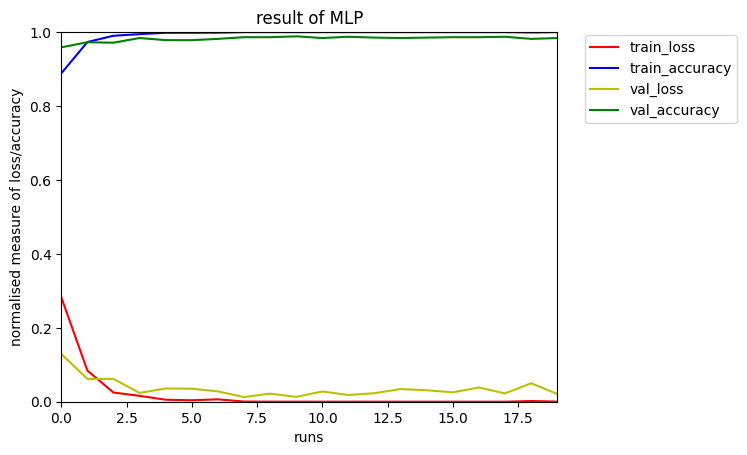

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(eval_acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of the model')
loss=np.asarray(train_loss)/max(train_loss)
plt.plot(x_len, train_loss, 'r',label="train_loss")
plt.plot(x_len, train_acc, 'b', label="train_accuracy")
plt.plot(x_len, eval_loss, 'y', label="val_loss")
plt.plot(x_len, eval_acc, 'g', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [ ]:
best_num_epoch = eval_acc.index(max(eval_acc))
best_num_epoch

9

In [ ]:
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

loaded_model = AutoModelForSequenceClassification. \
from_pretrained(f'./model_epoch_{9}')

In [ ]:
from datasets import load_metric

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer_2 = CustomTrainer(
    model=loaded_model,
    eval_dataset=test_set,
    compute_metrics = compute_metrics)

In [ ]:
trainer_2.evaluate(test_set)

{'eval_loss': 0.1068444475531578,
 'eval_f1': 0.9808102345415778,
 'eval_runtime': 15.8644,
 'eval_samples_per_second': 30.383,
 'eval_steps_per_second': 3.845}

In [ ]:
test_set_df = pd.DataFrame(test_set)

test_result = trainer_2.predict(test_set)

In [ ]:
from scipy.special import logit, expit

def make_predictions(sample):
  return expit(sample).argmax()

def make_confi_scores(sample):
  return expit(sample)


predictions = list(map(make_predictions, test_result[0].tolist()))
confi_scores = list(map(make_confi_scores, test_result[0].tolist()))

In [ ]:
test_set_df['predictions'] = predictions

test_set_df['labels'] = test_set_df['labels'].map(lambda x: int(x))

test_set_df['conf_score'] = confi_scores

test_set_df['input_ids'] = test_set_df['input_ids'].map(lambda x: x.tolist())

wrong_cases = test_set_df[test_set_df['predictions']!=test_set_df['labels']].drop(columns = ['attention_mask'])

In [ ]:
wrong_cases

,answer,input_ids,labels,predictions,conf_score
33,[forwards also known as strikers are the playe...,"[0, 2709, 17337, 6, 67, 684, 25, 27870, 6, 32,...",0,1,"[0.38207934672118743, 0.5869656652488622]"
84,[the civil rights movement was a series of wor...,"[0, 133, 2366, 659, 2079, 21, 10, 651, 9, 3612...",0,1,"[0.028973740107260407, 0.9699382762826149]"
133,[mixing friendship and money whether thats loa...,"[0, 45628, 154, 9330, 8, 418, 6, 549, 14, 18, ...",0,1,"[0.015870052528581997, 0.9869255424679945]"
136,[the key is that you need to use your debit ca...,"[0, 133, 762, 16, 14, 47, 240, 7, 304, 110, 20...",0,1,"[0.008207550458158729, 0.9927659349961319]"
172,[washington dc has been the capital of the uni...,"[0, 22247, 6, 211, 4, 347, 4, 34, 57, 5, 812, ...",0,1,"[0.08418019903098688, 0.9191672627408634]"
182,[if your meaning of asset protection is buying...,"[0, 1106, 110, 3099, 9, 22, 2401, 594, 2591, 1...",0,1,"[0.3771231597457982, 0.6463393033396361]"
200,[noise reduction is the process of removing no...,"[0, 3084, 1496, 4878, 16, 5, 609, 9, 8201, 649...",0,1,"[0.026351731232752987, 0.9765534959256601]"
363,[im not certain about international transfers ...,"[0, 100, 437, 45, 1402, 59, 758, 12291, 6, 53,...",0,1,"[0.08553389437995633, 0.915786139950541]"
441,[i dont know about an actual example now but i...,"[0, 100, 218, 75, 216, 59, 41, 3031, 1246, 122...",0,1,"[0.05066061516160422, 0.9527971351226574]"


In [ ]:
wrong_cases.to_csv('wrong_cases.csv')